# Machine Learning Zoomcamp - Capstone Project 1 - Terrain Image Classification

As described on the Readme.md file, in this project we'll train and tune a Convolutional Neural Network model to classify image terraings.

The dataset is available at Zenodo.org at [this address]('https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1')

Lets download the dataset

## Download dataset

In [1]:
!wget https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip

--2024-12-30 16:07:42--  https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94658721 (90M) [application/octet-stream]
Saving to: ‘EuroSAT_RGB.zip’

EuroSAT_RGB.zip     100%[===================>]  90.27M  7.08MB/s    in 14s     

2024-12-30 16:07:58 (6.26 MB/s) - ‘EuroSAT_RGB.zip’ saved [94658721/94658721]



After downloading the file, lets see the content of the directory:

In [2]:
!ls

EuroSAT_RGB.zip


We extract the data from the zip file downloaded

In [2]:
!unzip -q EuroSAT_RGB.zip

Lets take a look again at the folder and the content of the folder we just extracted

In [4]:
!ls

EuroSAT_RGB  EuroSAT_RGB.zip


In [5]:
!ls EuroSAT_RGB

AnnualCrop  HerbaceousVegetation  Industrial  PermanentCrop  River
Forest	    Highway		  Pasture     Residential    SeaLake


We can see there are 10 different classes of terrain, but the images are not yet distributed as train, test and validation, so we need to do that

## Data Preparation and split

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split


In [4]:
categories = os.listdir('EuroSAT_RGB')
categories

['AnnualCrop',
 'SeaLake',
 'River',
 'Highway',
 'HerbaceousVegetation',
 'Forest',
 'Industrial',
 'Pasture',
 'Residential',
 'PermanentCrop']

For our model training, we need to create folders for train, test and evaluation.

Additionally, as we have 10 different classes of terrain, we need to create folders with these classes inside the training, testing and evaluation forlder

In [5]:
for dir_name in ['train', 'val', 'test']:
    for cat in categories:
      os.makedirs(dir_name, exist_ok=True)
      os.makedirs(os.path.join(dir_name, cat), exist_ok=True)

In [9]:
!ls

EuroSAT_RGB  EuroSAT_RGB.zip  test  train  val


If we look inside the train folder we should see folders for each of the categories

In [10]:
!ls train

AnnualCrop  HerbaceousVegetation  Industrial  PermanentCrop  River
Forest	    Highway		  Pasture     Residential    SeaLake


Now we do the train, test, validation split, meaning that we are making a distribution of the images of each of the 10 classes available, inside the train, test and validation folders and subfolders.

In [6]:
for cat in categories:
  image_paths = []
  for img in os.listdir(os.path.join('EuroSAT_RGB/', cat)):
    image_paths.append(os.path.join('EuroSAT_RGB/', cat, img))
  print(cat, len(image_paths))
  full_train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)
  train_paths, val_paths = train_test_split(full_train_paths, test_size=0.25, random_state=42)
  for path in train_paths:
    image = path.split('/')[-1]
    shutil.copy(path, os.path.join('train', cat, image))
  for path in val_paths:
    image = path.split('/')[-1]
    shutil.copy(path, os.path.join('val', cat, image))
  for path in test_paths:
    image = path.split('/')[-1]
    shutil.copy(path, os.path.join('test', cat, image))

AnnualCrop 3000
SeaLake 3000
River 2500
Highway 2500
HerbaceousVegetation 3000
Forest 3000
Industrial 2500
Pasture 2000
Residential 3000
PermanentCrop 2500


Just to make sure the images are splitted right, we can list and get the number of files per folder/subfolder. Lets take the AnnualCrop subfolder as an example.

In [12]:
!ls -l test/AnnualCrop|wc -l

601


In [13]:
!ls -l train/AnnualCrop|wc -l

1801


In [14]:
!ls -l val/AnnualCrop|wc -l

601


As it can be seen the distribution of files is right in terms of train, test, val

## Training and Tunning the Model

For training and tunning the model we'll use three parameters:
- Learning rate
- Dropout rate
- Data augmentation

In [7]:
# Lets import the libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [8]:
!python --version

Python 3.10.12


/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [9]:
tf.__version__

'2.17.0'

### Basic parameters

In [10]:
# Define paths and parameters
main_dir = os.getcwd()
train_dir = os.path.join(main_dir, 'train')
test_dir = os.path.join(main_dir, 'test')
val_dir = os.path.join(main_dir, 'val')
img_width, img_height = 150, 150
batch_size = 32
num_classes = 10  # Adjust based on the number of classes
epochs = 35

### Image preparation

In [11]:
# Create ImageDataGenerator objects
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
# Load and preprocess data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 16200 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


### Make Model function

In order to make it easy to test and tune the parameters, we are going to define a function that actually create the model considering the parameters indicated previously (learning rate, dropout rate, data augmentation)


In [13]:
def make_model(learning_rate, dropout_rate=0.5):
  optimizer = Adam(learning_rate=learning_rate)  # Set your desired learning rate here
  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

### Checkpoints

We are also going to setup checkpoints to save the best accuracy models.

As we are goint to make different tests based on changing the tunning parameters, we'll be saving the model with different versions, depending on the parameter we are testing.

In this case v1 will be related to the tunning of the learning_rate

In [22]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'model_v1_{epoch:02d}_{val_accuracy:.3f}.h5.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

We are going to store the results of each model fit in a dictionary (scores) so we can have all the data at hand and select the best parameters

In [23]:
scores_lr = {}
for lr in [0.0001, 0.001]:
  print(lr)
  model = make_model(learning_rate=lr)
  history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint])
  scores_lr[lr] = history.history
  test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
  print('Test accuracy:', test_acc)

0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/35


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


506/506 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.2362 - loss: 2.0386 - val_accuracy: 0.4799 - val_loss: 1.5006
Epoch 2/35
  1/506 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2812 - loss: 1.7626

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2812 - loss: 1.7626 - val_accuracy: 0.2500 - val_loss: 1.8107
Epoch 3/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.3919 - loss: 1.6155 - val_accuracy: 0.5822 - val_loss: 1.2924
Epoch 4/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 35us/step - accuracy: 0.4062 - loss: 1.5282 - val_accuracy: 0.5417 - val_loss: 1.3890
Epoch 5/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.4626 - loss: 1.4554 - val_accuracy: 0.5874 - val_loss: 1.1791
Epoch 6/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5938 - loss: 1.4287 - val_accuracy: 0.6250 - val_loss: 0.9826
Epoch 7/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4914 - loss: 1.3680 - val_accuracy: 0.6198 - val_loss: 1.1047
Epoch 8/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 33us/step - accuracy: 0.6250 - loss: 1.0774 - val_accuracy: 0.4583 - val_loss: 1.1383
Epoch 9/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5266 - loss: 1.2930 - val_accuracy: 0.6

In [14]:
from matplotlib import pyplot as plt

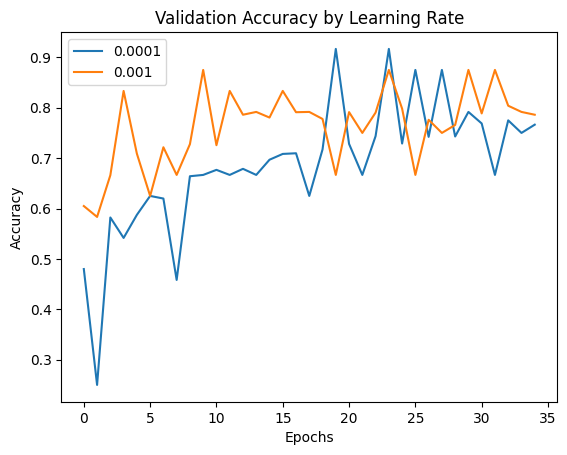

In [25]:
for lr, hist in scores_lr.items():
  plt.plot(hist['val_accuracy'], label=lr)
  plt.title("Validation Accuracy by Learning Rate")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()

Based on this result, the best learning rate would be **0.001** as it shows more stable

### Dropout Rate
Now we'll try different values for the dropout rate


In [15]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'model_v2_{epoch:02d}_{val_accuracy:.3f}.h5.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [17]:
learning_rate = 0.001
scores_dr = {}

for dr in [0, 0.1, 0.5]:
    print(dr)
    model = make_model(learning_rate=learning_rate, dropout_rate=dr)
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        callbacks=[checkpoint])
    scores_dr[dr] = history.history
    test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
    print('Test accuracy:', test_acc)

0
Epoch 1/35


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


506/506 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.4042 - loss: 1.6100 - val_accuracy: 0.6196 - val_loss: 1.0039
Epoch 2/35
  1/506 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.4688 - loss: 1.3143

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4688 - loss: 1.3143 - val_accuracy: 0.6667 - val_loss: 1.2281
Epoch 3/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6561 - loss: 0.9646 - val_accuracy: 0.6747 - val_loss: 0.8763
Epoch 4/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 30us/step - accuracy: 0.7500 - loss: 0.7571 - val_accuracy: 0.6667 - val_loss: 0.9538
Epoch 5/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.7388 - loss: 0.7207 - val_accuracy: 0.7381 - val_loss: 0.7188
Epoch 6/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8438 - loss: 0.6000 - val_accuracy: 0.8333 - val_loss: 0.6882
Epoch 7/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.8029 - loss: 0.5575 - val_accuracy: 0.7026 - val_loss: 0.8883
Epoch 8/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 38us/step - accuracy: 0.7812 - loss: 0.6118 - val_accuracy: 0.8333 - val_loss: 0.4232
Epoch 9/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.8500 - loss: 0.4171 - val_accuracy: 0.7

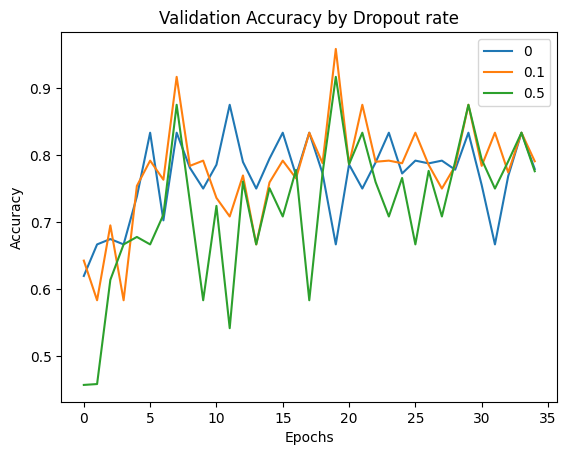

In [18]:
for dr, hist in scores_dr.items():
  if (dr in [0, 0.1, 0.5]):
    plt.plot(hist['val_accuracy'], label=dr)
    plt.title("Validation Accuracy by Dropout rate")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

Based on these results, at lower epochs the best **Dropout rate** is 0.1, but at higher epochs we get better results with Dropout rates of 0 and 0.1. For the final decision, we use the Test Accuracy result which was better with a **Dropout Rate of 0.1**

### Data Augmentation

The final step of the tunning of the model would be based on data augmentation.

For this we are going to include additional parameters at the moment when we use the ImageDataGenerator at the training data

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.05,
    rotation_range=20,    
    horizontal_flip=True)


In [20]:
# Load and preprocess data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 16200 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [21]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'model_v3_{epoch:02d}_{val_accuracy:.3f}.h5.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [22]:
learning_rate = 0.0001
dropout_rate = 0.1
batch_size = 32
scores_aug = {}

model = make_model(learning_rate=learning_rate, dropout_rate=dropout_rate)
history = model.fit(
  train_generator,
  steps_per_epoch=train_generator.samples // batch_size,
  epochs=epochs,
  validation_data=validation_generator,
  validation_steps=validation_generator.samples // batch_size,
  callbacks=[checkpoint])
scores_aug['augment'] = history.history
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_acc)

Epoch 1/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 81s 153ms/step - accuracy: 0.3140 - loss: 1.8380 - val_accuracy: 0.5164 - val_loss: 1.3466
Epoch 2/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - accuracy: 0.7188 - loss: 1.0743 - val_accuracy: 0.4167 - val_loss: 1.3512
Epoch 3/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 79s 155ms/step - accuracy: 0.5103 - loss: 1.3260 - val_accuracy: 0.6023 - val_loss: 1.1174
Epoch 4/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 38us/step - accuracy: 0.5938 - loss: 1.2327 - val_accuracy: 0.5000 - val_loss: 1.3125
Epoch 5/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 78s 153ms/step - accuracy: 0.5753 - loss: 1.1642 - val_accuracy: 0.6496 - val_loss: 0.9973
Epoch 6/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 34us/step - accuracy: 0.5938 - loss: 1.1138 - val_accuracy: 0.5000 - val_loss: 1.1354
Epoch 7/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 78s 151ms/step - accuracy: 0.6092 - loss: 1.0788 - val_accuracy: 0.6615 - val_loss: 0.9926
Epoch 8/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6250 - loss: 1.1859 - 

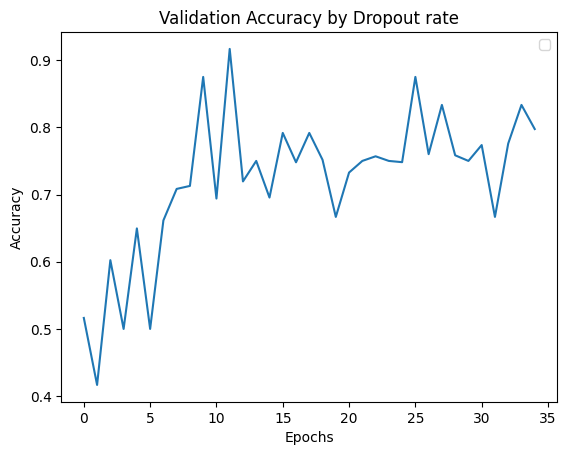

In [23]:
for aug, hist in scores_aug.items():
    plt.plot(hist['val_accuracy'])
    plt.title("Validation Accuracy by Dropout rate")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

We got good validation results after augmenting the data at higher epochs and got good validation accuracy

## Final model definition

We'll train once again the model with the final parameters

In [27]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.02,
    rotation_range=15,    
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)


In [28]:
# Load and preprocess data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 16200 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [29]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'model_vf_{epoch:02d}_{val_accuracy:.3f}.h5.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

## Adding a new Layer

Additional to the parameter tunning I will add a third convolutional layer block.

In [30]:
def make_model(learning_rate, dropout_rate=0.5):
    optimizer = Adam(learning_rate=learning_rate)
    model = Sequential()

    # First convolutional block
    model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), activation='relu', padding='same')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third convolutional block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same')) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [31]:
learning_rate = 0.001
dropout_rate = 0.1
batch_size = 32
scores = {}

model = make_model(learning_rate=learning_rate, dropout_rate=dropout_rate)
history = model.fit(
  train_generator,
  steps_per_epoch=train_generator.samples // batch_size,
  epochs=epochs,
  validation_data=validation_generator,
  validation_steps=validation_generator.samples // batch_size,
  callbacks=[checkpoint])
scores['final'] = history.history
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_acc)

Epoch 1/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 83s 154ms/step - accuracy: 0.3494 - loss: 1.7463 - val_accuracy: 0.6019 - val_loss: 1.0497
Epoch 2/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5312 - loss: 1.2911 - val_accuracy: 0.9167 - val_loss: 0.7065
Epoch 3/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 76s 149ms/step - accuracy: 0.6157 - loss: 1.0602 - val_accuracy: 0.7262 - val_loss: 0.7629
Epoch 4/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 37us/step - accuracy: 0.6875 - loss: 0.9176 - val_accuracy: 0.6250 - val_loss: 1.0244
Epoch 5/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 77s 150ms/step - accuracy: 0.7006 - loss: 0.8231 - val_accuracy: 0.7316 - val_loss: 0.7432
Epoch 6/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 37us/step - accuracy: 0.7500 - loss: 0.6388 - val_accuracy: 0.6667 - val_loss: 0.7793
Epoch 7/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 77s 151ms/step - accuracy: 0.7358 - loss: 0.7282 - val_accuracy: 0.7520 - val_loss: 0.6720
Epoch 8/35
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 42us/step - accuracy: 0.8125 - loss: 0.5057 - v

In [32]:
model.save('model_final_version_lr0.001_dr0.1_augmented.h5.keras')

In [33]:
class_indices = train_generator.class_indices
class_indices

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}